# Simuler l'évolution de l'épaisseur d'un glacier en fonction de l'augmentation moyenne des températures

In [140]:
from oggm import cfg
from oggm import tasks, utils, workflow, graphics, DEFAULT_BASE_URL
import xarray as xr
import matplotlib.pyplot as plt
from oggm.sandbox import distribute_2d
from matplotlib import animation
from IPython.display import HTML, display
from matplotlib_scalebar.scalebar import ScaleBar


In [158]:
def sim_thick_by_temp_anim(animation_name = "animation.html", glacier_name = 'RGI60-15.03473', ys=2020, ye=2100, temperature_bias=1.5, init_model_yr=2010):
    # Initialize OGGM and set up the default run parameters
    cfg.initialize(logging_level='WARNING')

    # Local working directory (where OGGM will write its output)
    # WORKING_DIR = utils.gettempdir('OGGM_distr4')
    cfg.PATHS['working_dir'] = utils.get_temp_dir('OGGM_distributed', reset=True)

    rgi_ids = [glacier_name]  # This is Aletsch
    gdir = workflow.init_glacier_directories(rgi_ids, prepro_base_url=DEFAULT_BASE_URL, from_prepro_level=4, prepro_border=80)[0]

    # Do a random run with a bit of warming
    tasks.run_random_climate(gdir, 
                         init_model_yr = init_model_yr,
                         ys=ys, ye=ye,  # Although the simulation is idealised, lets use real dates for the animation
                         y0=2000, halfsize=10,  # Randome climate of 1999-2019
                         seed=1,  # Random number generator seed 
                         temperature_bias=temperature_bias,  # additional warming - change for other scenarios
                         store_fl_diagnostics=True,  # important! This will be needed for the redistribution
                         init_model_filesuffix='_spinup_historical',  # start from the spinup run
                         output_filesuffix='_random_s1',  # optional - here I just want to make things explicit as to which run we are using afterwards
                        );

    # This is to add a new topography to the file (smoothed differently)
    distribute_2d.add_smoothed_glacier_topo(gdir)
    # This is to get the bed map at the start of the simulation
    tasks.distribute_thickness_per_altitude(gdir)
    # This is to prepare the glacier directory for the interpolation (needs to be done only once)
    distribute_2d.assign_points_to_band(gdir)

    with xr.open_dataset(gdir.get_filepath('gridded_data')) as ds:
        ds = ds.load()


    ds = distribute_2d.distribute_thickness_from_simulation(gdir, input_filesuffix='_random_s1')





    image = plt.imread('lyon_annote.png')
    thk = ds['distributed_thickness'];

    fig, ax = plt.subplots();

    thk = ds['distributed_thickness'];

    # Plot the initial frame. 
    cax = thk.isel(time=0).plot(ax=ax,
        add_colorbar=True,
        cmap='viridis',
        vmin=0, vmax=350,  
    )

    # Définir les limites des axes
    # ax.set_xlim([-4500, 3000])
    # ax.set_ylim([5.075 * 1e6, 5.09 * 1e6])

    # # Ajouter une échelle horizontale
    # scalebar = ScaleBar(1, location='lower right')  # 1 mètre équivalent à 1 unité de l'axe
    # ax.add_artist(scalebar)

    ax.imshow(image, extent=[-11000, 9000, 5.070 * 1e6, 5.095 * 1e6], alpha=0.5)

    # # Ajouter une échelle verticale
    # scalebar_vertical = ScaleBar(1, location='upper right', scale_loc='right', rotation="vertical")  # 1 mètre équivalent à 1 unité de l'axe
    # ax.add_artist(scalebar_vertical)

    ax.axis('off')

    # Ajuster l'aspect des axes pour qu'ils soient égaux
    ax.set_aspect('equal')

    def animate(frame):
        
        ax.set_title(f'Year {int(thk.time[frame])}')
        cax.set_array(thk.values[frame, :].flatten())

    ani_glacier = animation.FuncAnimation(fig, animate, frames=len(thk.time), interval=100);

    # Générer le code HTML de l'animation
    animation_html = ani_glacier.to_jshtml();

    HTML(ani_glacier.to_jshtml())
    # Écrire le code HTML dans un fichier
    with open(animation_name, "w") as html_file:
        html_file.write(animation_html);

In [142]:
import re

def remove_anim_buttons(input_code):
    # Modèle de recherche pour les balises anim-buttons
    anim_buttons_pattern = re.compile(r'<div class="anim-buttons">.*?</div>', re.DOTALL)
    # Suppression du contenu des balises anim-buttons
    output_code = re.sub(anim_buttons_pattern, '', input_code)
    return output_code

def remove_form(input_code):
    # Modèle de recherche pour les balises anim-state
    anim_state_pattern = re.compile(r'<form.*?</form>', re.DOTALL)
    # Suppression du contenu des balises anim-state
    output_code = re.sub(anim_state_pattern, '', input_code)
    return output_code

def process_file(file_name):
    # Lecture du contenu du fichier
    with open(file_name, 'r') as file:
        input_code = file.read()

    # Suppression du contenu des balises anim-buttons
    output_code = remove_anim_buttons(input_code)
    # Suppression du contenu des balises anim-state
    output_code = remove_form(output_code)

    # Écriture du code converti dans le fichier
    with open(file_name, 'w') as file:
        file.write(output_code)

2024-05-02 12:51:27: oggm.cfg: Reading default parameters from the OGGM `params.cfg` configuration file.
2024-05-02 12:51:27: oggm.cfg: Multiprocessing switched OFF according to the parameter file.
2024-05-02 12:51:27: oggm.cfg: Multiprocessing: using all available processors (N=8)
2024-05-02 12:51:29: oggm.workflow: init_glacier_directories from prepro level 4 on 1 glaciers.
2024-05-02 12:51:29: oggm.workflow: Execute entity tasks [gdir_from_prepro] on 1 glaciers


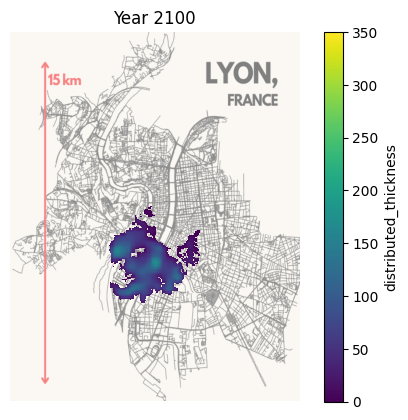

In [159]:
file_name = "evolution_mer_de_glace_1_5.html"
rgi_id = 'RGI60-11.03643'
temp_bias = 1.5
sim_thick_by_temp_anim(file_name, rgi_id, 2010, 2100, temp_bias, 2010);
# process_file(file_name)

In [ ]:
def initializa_gdir(glacier_name = 'RGI60-15.03473') :
    # Initialize OGGM and set up the default run parameters
    cfg.initialize(logging_level='WARNING')

    # Local working directory (where OGGM will write its output)
    # WORKING_DIR = utils.gettempdir('OGGM_distr4')
    cfg.PATHS['working_dir'] = utils.get_temp_dir('OGGM_distributed', reset=True)

    rgi_ids = [glacier_name]  # This is Aletsch
    gdir = workflow.init_glacier_directories(rgi_ids, prepro_base_url=DEFAULT_BASE_URL, from_prepro_level=4, prepro_border=80)[0]
    return gdir

In [ ]:
gdir = initializa_gdir('RGI60-11.03643')

2024-04-30 14:37:40: oggm.cfg: Reading default parameters from the OGGM `params.cfg` configuration file.
2024-04-30 14:37:40: oggm.cfg: Multiprocessing switched OFF according to the parameter file.
2024-04-30 14:37:40: oggm.cfg: Multiprocessing: using all available processors (N=8)
2024-04-30 14:37:40: oggm.workflow: init_glacier_directories from prepro level 4 on 1 glaciers.
2024-04-30 14:37:40: oggm.workflow: Execute entity tasks [gdir_from_prepro] on 1 glaciers


In [ ]:
gdir

<oggm.GlacierDirectory>
  RGI id: RGI60-11.03643
  Region: 11: Central Europe
  Subregion: 11-01: Alps                            
  Name: Fr4N01236A01 Mer De Glace/Geant
  Glacier type: Glacier
  Terminus type: Land-terminating
  Status: Glacier or ice cap
  Area: 24.179 km2
  Lon, Lat: (6.934, 45.883)
  Grid (nx, ny): (234, 299)
  Grid (dx, dy): (79.0, -79.0)

In [ ]:
ds = utils.compile_run_output(gdir, input_filesuffix='_spinup_historical')

2024-04-30 14:40:59: oggm.utils: Applying global task compile_run_output on 1 glaciers
2024-04-30 14:40:59: oggm.utils: Applying compile_run_output on 1 gdirs.


In [ ]:
ds

<xarray.Dataset>
Dimensions:                   (time: 42, rgi_id: 1)
Coordinates:
  * time                      (time) float64 1.979e+03 1.98e+03 ... 2.02e+03
  * rgi_id                    (rgi_id) <U14 'RGI60-11.03643'
    hydro_year                (time) int64 1979 1980 1981 ... 2018 2019 2020
    hydro_month               (time) int64 4 4 4 4 4 4 4 4 4 ... 4 4 4 4 4 4 4 4
    calendar_year             (time) int64 1979 1980 1981 ... 2018 2019 2020
    calendar_month            (time) int64 1 1 1 1 1 1 1 1 1 ... 1 1 1 1 1 1 1 1
Data variables:
    volume                    (time, rgi_id) float64 2.275e+09 ... 1.723e+09
    volume_bsl                (time, rgi_id) float64 0.0 0.0 0.0 ... 0.0 0.0 0.0
    volume_bwl                (time, rgi_id) float64 0.0 0.0 0.0 ... 0.0 0.0 0.0
    area                      (time, rgi_id) float64 2.438e+07 ... 2.287e+07
    area_m2_min_h             (time, rgi_id) float64 2.438e+07 ... 2.287e+07
    length                    (time, rgi_id) float64 1.027e+04 ... 9.322e+03
    calving                   (time, rgi_id) float64 0.0 0.0 0.0 ... 0.0 0.0 0.0
    calving_rate              (time, rgi_id) float64 0.0 0.0 0.0 ... 0.0 0.0 0.0
    is_fixed_geometry_spinup  (time, rgi_id) float64 0.0 0.0 0.0 ... 0.0 0.0 0.0
    water_level               (rgi_id) float64 0.0
    glen_a                    (rgi_id) float64 6.078e-24
    fs                        (rgi_id) float64 0.0
Attributes:
    description:    OGGM model output
    oggm_version:   1.6.1
    calendar:       365-day no leap
    creation_date:  2024-04-30 12:40:59

In [64]:
# Initialize OGGM and set up the default run parameters
cfg.initialize(logging_level='WARNING')

# Local working directory (where OGGM will write its output)
# WORKING_DIR = utils.gettempdir('OGGM_distr4')
cfg.PATHS['working_dir'] = utils.get_temp_dir('OGGM_distributed', reset=True)

rgi_ids = ['RGI60-11.03643']  # This is la mer de glace
gdir = workflow.init_glacier_directories(rgi_ids, prepro_base_url=DEFAULT_BASE_URL, from_prepro_level=4, prepro_border=80)[0]

# Do a random run with a bit of warming
tasks.run_random_climate(gdir, 
                        init_model_yr = 2010,
                        ys=2010, ye=2100,  # Although the simulation is idealised, lets use real dates for the animation
                        y0=2000, halfsize=10,  # Randome climate of 1999-2019
                        seed=1,  # Random number generator seed 
                        temperature_bias=1.5,  # additional warming - change for other scenarios
                        store_fl_diagnostics=True,  # important! This will be needed for the redistribution
                        init_model_filesuffix='_spinup_historical',  # start from the spinup run
                        output_filesuffix='_random_s1',  # optional - here I just want to make things explicit as to which run we are using afterwards
                    );

# This is to add a new topography to the file (smoothed differently)
distribute_2d.add_smoothed_glacier_topo(gdir)
# This is to get the bed map at the start of the simulation
tasks.distribute_thickness_per_altitude(gdir)
# This is to prepare the glacier directory for the interpolation (needs to be done only once)
distribute_2d.assign_points_to_band(gdir)

with xr.open_dataset(gdir.get_filepath('gridded_data')) as ds:
    ds = ds.load()


ds = distribute_2d.distribute_thickness_from_simulation(gdir, input_filesuffix='_random_s1')



2024-05-02 10:37:28: oggm.cfg: Reading default parameters from the OGGM `params.cfg` configuration file.
2024-05-02 10:37:28: oggm.cfg: Multiprocessing switched OFF according to the parameter file.
2024-05-02 10:37:28: oggm.cfg: Multiprocessing: using all available processors (N=8)
2024-05-02 10:37:29: oggm.workflow: init_glacier_directories from prepro level 4 on 1 glaciers.
2024-05-02 10:37:29: oggm.workflow: Execute entity tasks [gdir_from_prepro] on 1 glaciers


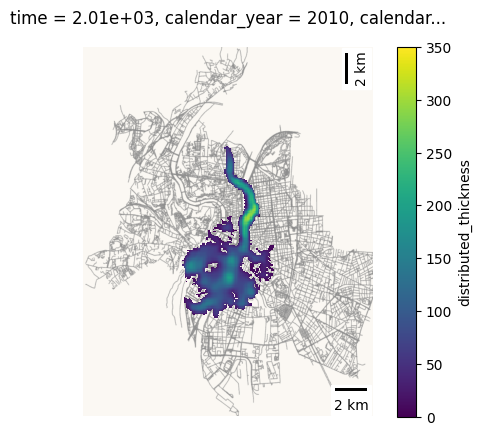

In [139]:
# Animation
import matplotlib.pyplot as plt
from matplotlib_scalebar.scalebar import ScaleBar

image = plt.imread('lyon.png')


thk = ds['distributed_thickness'];

fig, ax = plt.subplots();

thk = ds['distributed_thickness'];

# Plot the initial frame. 
cax = thk.isel(time=0).plot(ax=ax,
    add_colorbar=True,
    cmap='viridis',
    vmin=0, vmax=350,  
)

# Définir les limites des axes
# ax.set_xlim([-4500, 3000])
# ax.set_ylim([5.075 * 1e6, 5.09 * 1e6])

# Ajouter une échelle horizontale
scalebar = ScaleBar(1, location='lower right')  # 1 mètre équivalent à 1 unité de l'axe
ax.add_artist(scalebar)

ax.imshow(image, extent=[-11000, 9000, 5.070 * 1e6, 5.095 * 1e6], alpha=0.5)

# Ajouter une échelle verticale
scalebar_vertical = ScaleBar(1, location='upper right', scale_loc='right', rotation="vertical")  # 1 mètre équivalent à 1 unité de l'axe
ax.add_artist(scalebar_vertical)

ax.axis('off')

# Ajuster l'aspect des axes pour qu'ils soient égaux
ax.set_aspect('equal')


In [79]:
ds['distributed_thickness'].tail

<bound method DataArray.tail of <xarray.DataArray 'distributed_thickness' (time: 91, y: 299, x: 234)>
array([[[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
...
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..